# Traditional Logistic Regression Approach using StatsModels

Traditional logistic regression, as implemented in libraries like `statsmodels`, is typically fitted using **Maximum Likelihood Estimation (MLE)**. The goal of MLE is to find the model parameters (coefficients) that maximize the probability (likelihood) of observing the actual outcome data given the predictor variables. This optimization problem is often solved using iterative numerical methods like **Iteratively Reweighted Least Squares (IRLS)** or **Newton-Raphson**, which utilize second-derivative information (the Hessian matrix) for faster convergence, especially on smaller datasets. The emphasis is often on statistical inference, providing detailed summaries with p-values, confidence intervals, and goodness-of-fit tests.

In contrast, the machine learning approach often fits logistic regression by minimizing a **cost function** (like log-loss or cross-entropy, which is equivalent to maximizing the likelihood) using optimization algorithms like **Gradient Descent** (or its variants like Stochastic Gradient Descent, Mini-batch Gradient Descent, Adam, etc.). Gradient Descent iteratively adjusts the model parameters in the direction opposite to the gradient of the cost function. It primarily uses first-derivative information (the gradient). This approach scales better to very large datasets where computing the Hessian matrix for IRLS/Newton's method can be computationally expensive. The focus in the machine learning context is typically more on predictive performance and generalization to unseen data, often incorporating regularization techniques (L1/L2) directly into the cost function to prevent overfitting.

**Traditional Statistical Approach (e.g., `statsmodels` using MLE/IRLS):**

*   **Rich Inference:** Provides detailed statistical summaries, including p-values, confidence intervals for coefficients (and odds ratios), standard errors, and goodness-of-fit measures. This is useful for understanding the significance and uncertainty associated with each predictor.
*   **Interpretability Focus:** Emphasizes interpreting model coefficients (often as odds ratios) and their statistical significance in the context of the data.
*   **Exact Solutions:** Optimization methods like IRLS often converge to the precise Maximum Likelihood Estimate.
*   **Efficiency on Smaller Data:** Can converge faster on smaller datasets due to using second-order information (Hessian matrix).

**Machine Learning Approach (e.g., `scikit-learn` using Gradient Descent):**

*   **Scalability:** Handles very large datasets (large number of samples or features) more efficiently as it avoids computationally expensive matrix inversions required by methods like Newton-Raphson.
*   **Regularization:** Easily incorporates L1 and L2 regularization to prevent overfitting and perform implicit feature selection, improving generalization to new data.
*   **Flexibility:** Variants like Stochastic Gradient Descent (SGD) allow for online learning (updating the model as new data arrives).
*   **Optimization Focus:** Primarily optimized for predictive performance on unseen data.
*   **Pipeline Integration:** Integrates smoothly into standard machine learning workflows involving preprocessing, cross-validation, and hyperparameter tuning.

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from src.data.loading import load_and_preprocess_data
from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from sklearn.preprocessing import StandardScaler
from src.data.splitting import split_data_for_sklearn

plt.rcParams["font.family"] = ["Roboto", "Arial", "sans-serif"]

In [2]:
df = load_and_preprocess_data(biochem=False)
random_seed = RANDOM_SEED
output_path = "output/statsmodels/"

In [3]:
columns_to_drop = [
    "baseline_eims_arthralgia_arthritis",
    "baseline_eims_ankylosing_spondylitis",
    "baseline_eims_erythema_nodosum",
    "baseline_eims_uveitis",
    "baseline_eims_scleritis_episclerities",
    "is_smoker_smokeryn1",
    "study_group_name_Await Dx",
    "ifx_drug_level",
    "ada_drug_level",
    "ifx_drug_level_present",
    "ada_drug_level_present",
    "ifx_antibody_present",
    "ada_antibody_present",
    "haematocrit",
]

df.drop(columns=columns_to_drop, inplace=True)

numerical_features = NUMERICAL_FEATURES
numerical_features = [
    col
    for col in numerical_features
    if col not in ["haematocrit", "ada_drug_level", "ifx_drug_level"]
]

In [4]:
scaler = StandardScaler()
scaler.fit(df[numerical_features])
df[numerical_features] = scaler.transform(df[numerical_features])

In [ ]:
X_train, X_test, y_train, y_test, groups = split_data_for_sklearn(df)

In [6]:
# Add a constant (intercept) to the features matrix for statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test) # Also add to test set for prediction

# Instantiate the logistic regression model
# Using Logit for binary classification
logit_model = sm.Logit(y_train, X_train_sm)

# Fit the model using Maximum Likelihood Estimation (MLE)
# statsmodels automatically selects an appropriate solver (like IRLS)
logit_result = logit_model.fit()

# Print the detailed summary
print(logit_result.summary())

# --- Save the fitted model result ---
model_filename = f'{output_path}/statsmodels_logreg.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(logit_result, file)


         Current function value: 0.491819
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        fatigue_outcome   No. Observations:                  962
Model:                          Logit   Df Residuals:                      896
Method:                           MLE   Df Model:                           65
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.2904
Time:                        11:02:40   Log-Likelihood:                -473.13
converged:                      False   LL-Null:                       -666.79
Covariance Type:            nonrobust   LLR p-value:                 2.224e-47
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                             

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Significant features (p < 0.05): ['sex', 'has_active_symptoms', 'crp', 'platelets', 'sampling_steroids', 'sampling_mp', 'sampling_ada', 'study_group_name_UC']


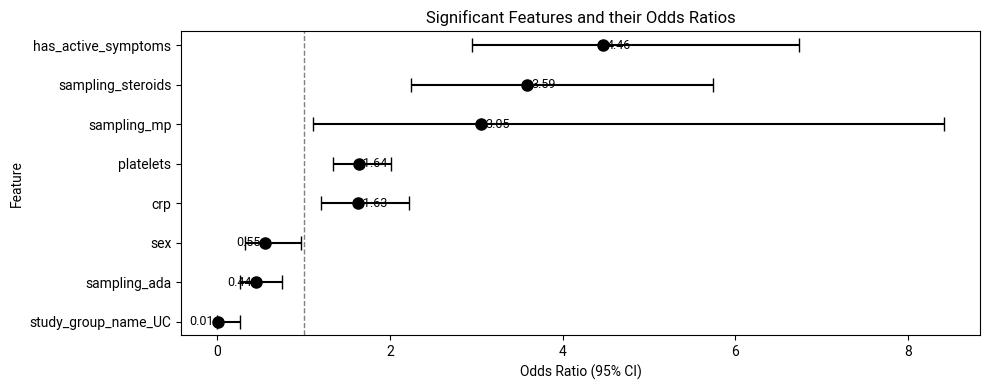

In [7]:

# --- Identify Significant Features ---
p_values = logit_result.pvalues
significant_features = p_values[p_values < 0.05].index.tolist()

# Remove the intercept if it's significant (optional, usually not plotted)
if 'const' in significant_features:
    significant_features.remove('const')

print(f"Significant features (p < 0.05): {significant_features}")

# --- Get Coefficients, Odds Ratios, and Confidence Intervals ---
params = logit_result.params[significant_features]
conf = logit_result.conf_int().loc[significant_features]
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# Calculate Odds Ratios and their CIs
odds_ratios = np.exp(conf)

# Sort by Odds Ratio for plotting
odds_ratios = odds_ratios.sort_values(by='Odds Ratio')


# --- Plotting Significant Features ---
if not odds_ratios.empty:
    fig, ax = plt.subplots(figsize=(10, len(odds_ratios) * 0.5)) # Adjust size as needed

    # Plot confidence intervals
    errors = [odds_ratios['Odds Ratio'] - odds_ratios['2.5%'],
              odds_ratios['97.5%'] - odds_ratios['Odds Ratio']]
    ax.errorbar(odds_ratios['Odds Ratio'], odds_ratios.index, xerr=errors,
                fmt='o', color='black', capsize=5, linestyle='None', markersize=8,
                label='Odds Ratio (95% CI)')

    # Add a vertical line at OR = 1 (no effect)
    ax.axvline(x=1, linestyle='--', color='grey', linewidth=1)

    # Add OR values as text
    for i, or_val in enumerate(odds_ratios['Odds Ratio']):
        ax.text(or_val + 0.05 * np.sign(or_val -1) , i, f'{or_val:.2f}', va='center', ha='left' if or_val > 1 else 'right', fontsize=9)


    ax.set_xlabel('Odds Ratio (95% CI)')
    ax.set_ylabel('Feature')
    ax.set_title('Significant Features and their Odds Ratios')
    # Consider log scale if ORs vary widely
    # ax.set_xscale('log')
    plt.tight_layout()
    plt.show()
else:
    print("No features were statistically significant at p < 0.05.")


Statsmodels Logit AUC: 0.7085


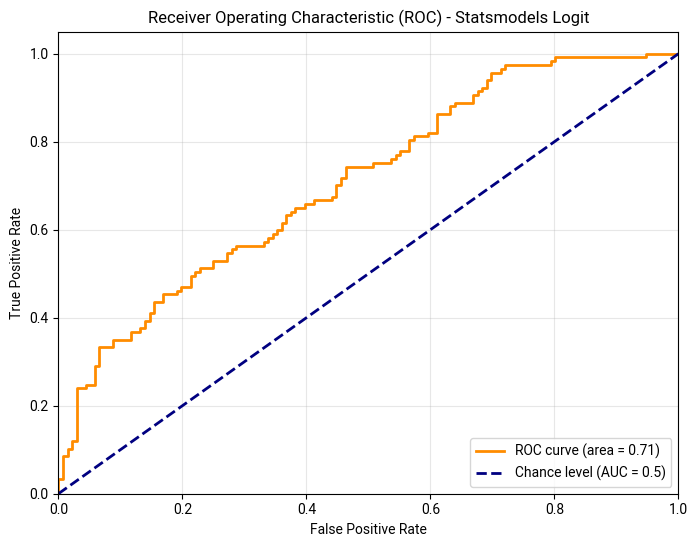

In [8]:
# Add this as a new cell
from sklearn.metrics import roc_curve, auc, roc_auc_score

# --- Predict Probabilities on the Test Set ---
# Use the X_test_sm which includes the constant term
y_pred_prob_sm = logit_result.predict(X_test_sm)

# --- Calculate ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sm)
roc_auc = auc(fpr, tpr)
# Alternatively, calculate AUC directly:
# roc_auc = roc_auc_score(y_test, y_pred_prob_sm)

print(f"Statsmodels Logit AUC: {roc_auc:.4f}")

# --- Plot ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Statsmodels Logit')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [9]:

# Extract coefficients, p-values, and confidence intervals
summary_df = pd.DataFrame({
    'Coefficient (Log-Odds)': logit_result.params,
    'Std.Err.': logit_result.bse,
    'z': logit_result.tvalues, # Note: statsmodels uses tvalues attribute, but it's z for Logit
    'P>|z|': logit_result.pvalues,
    '[0.025': logit_result.conf_int()[0],
    '0.975]': logit_result.conf_int()[1]
})

# Calculate Odds Ratios
summary_df['Odds Ratio'] = np.exp(summary_df['Coefficient (Log-Odds)'])
summary_df['OR [0.025'] = np.exp(summary_df['[0.025'])
summary_df['OR 0.975]'] = np.exp(summary_df['0.975]'])

# Sort by p-value (ascending)
summary_df_sorted = summary_df.sort_values(by='P>|z|')

# Select and reorder columns for display
display_cols = [
    'Coefficient (Log-Odds)',
    'Odds Ratio',
    'Std.Err.',
    'z',
    'P>|z|',
    '[0.025',
    '0.975]',
    'OR [0.025',
    'OR 0.975]'
]
summary_df_sorted = summary_df_sorted[display_cols]


# Print the sorted table
print("Features Ranked by Significance (p-value):")
# Use pandas display options for better formatting if needed
# pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(summary_df_sorted)


Features Ranked by Significance (p-value):
                     Coefficient (Log-Odds)    Odds Ratio      Std.Err.  \
has_active_symptoms                1.495697  4.462447e+00      0.210388   
sampling_steroids                  1.278113  3.589860e+00      0.239263   
platelets                          0.494343  1.639421e+00      0.105111   
crp                                0.490239  1.632706e+00      0.157057   
sampling_ada                      -0.816984  4.417622e-01      0.270297   
...                                     ...           ...           ...   
season_spring                     17.956538  6.286741e+07   1585.375526   
season_winter                     17.865267  5.738346e+07   1585.375519   
season_summer                     17.582850  4.326480e+07   1585.375519   
const                            -16.524831  6.658207e-08   1585.376395   
sampling_risa                     18.972627  1.736630e+08  26464.897339   

                            z         P>|z|        [0.02

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
